In [1]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim

In [47]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 5e-4):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.RMSprop(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self = self.to('cuda')

In [60]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.SGD(self.parameters(), lr)
        self.loss = nn.BCEWithLogitsLoss()
        self = self.to('cuda')

    def training_step(self, true_data, fake_data, steps, var_discriminator):
        for step in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_data)
            var_discriminator[0] = (y_true < 0.5).sum() + (y_fake < 0.5).sum()
            loss_fake = self.loss(y_fake, torch.zeros_like(y_true).cuda())
            

            loss = loss_true + loss_fake
            loss.backward()
            self.optim.step()
        
        return loss

In [62]:
def plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, var_discriminator):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 10))

    # Wykres 1: Straty
    ax1.set_title(rf'Straty modeli dla $lr_{{gen}}$ = {generator.optim.param_groups[0]['lr']}, $lr_{{dyskryminator}}$ = {discriminator.optim.param_groups[0]['lr']}')
    ax1.plot(discriminator_losses, label='dyskryminator - BCE')
    ax1.plot(generator_losses, label='generator - MSE')
    ax1.legend()
    ax1.set_xlabel('epoka')
    ax1.set_ylabel('strata')

    # Wykres 2: Powierzchnia decyzyjna
    x_range = np.linspace(0, 25, num=1_000)
    y_range = np.linspace(0, 8, num=1_000)
    X, Y = np.meshgrid(x_range, y_range)
    mapa = torch.FloatTensor(np.column_stack([X.flatten(), Y.flatten()])).cuda()
    discriminator_assessment = discriminator.layers(mapa).cpu().detach().numpy().reshape(x_range.shape[0], y_range.shape[0])
    ax2.set_title('Powierzchnia decyzyjna dysriminatora\n0 - falszywa probka, 1 - prawdziwa probka')
    contour = ax2.contourf(X, Y, discriminator_assessment, levels=50)
    plt.colorbar(contour, ax=ax2)

    # Wykres 3: Próbki generatora
    noise = torch.randn(size=(20 * BATCH_SIZE, 128)).cuda()
    x, y = [], []
    output = generator.layers(noise).cpu().detach().numpy().reshape(-1, 2)
    x.extend(output[:, 0])
    y.extend(output[:, 1])
    x = np.array(x)
    y = np.array(y)
    ax3.set_title('Probki jakie wyrzuca generator dla szumu\nPowinien byc to rozklad greisena')
    ax3.scatter(x, y, s=0.1)

    ax4.set_title('Wariancje wyrzucanych przez generator danych wspolrzednych')
    ax4.plot(var_x, label='x')
    ax4.plot(var_y, label='y')
    ax4.plot(var_discriminator, label='Dyskryminator suma outputow')
    ax4.legend()
    ax4.set_xlabel('epoka')
    ax4.set_ylabel('sum(wspolrzedna)')

    plt.tight_layout()
    plt.savefig('./Wykresy/GAN/podsumowanie.jpg')

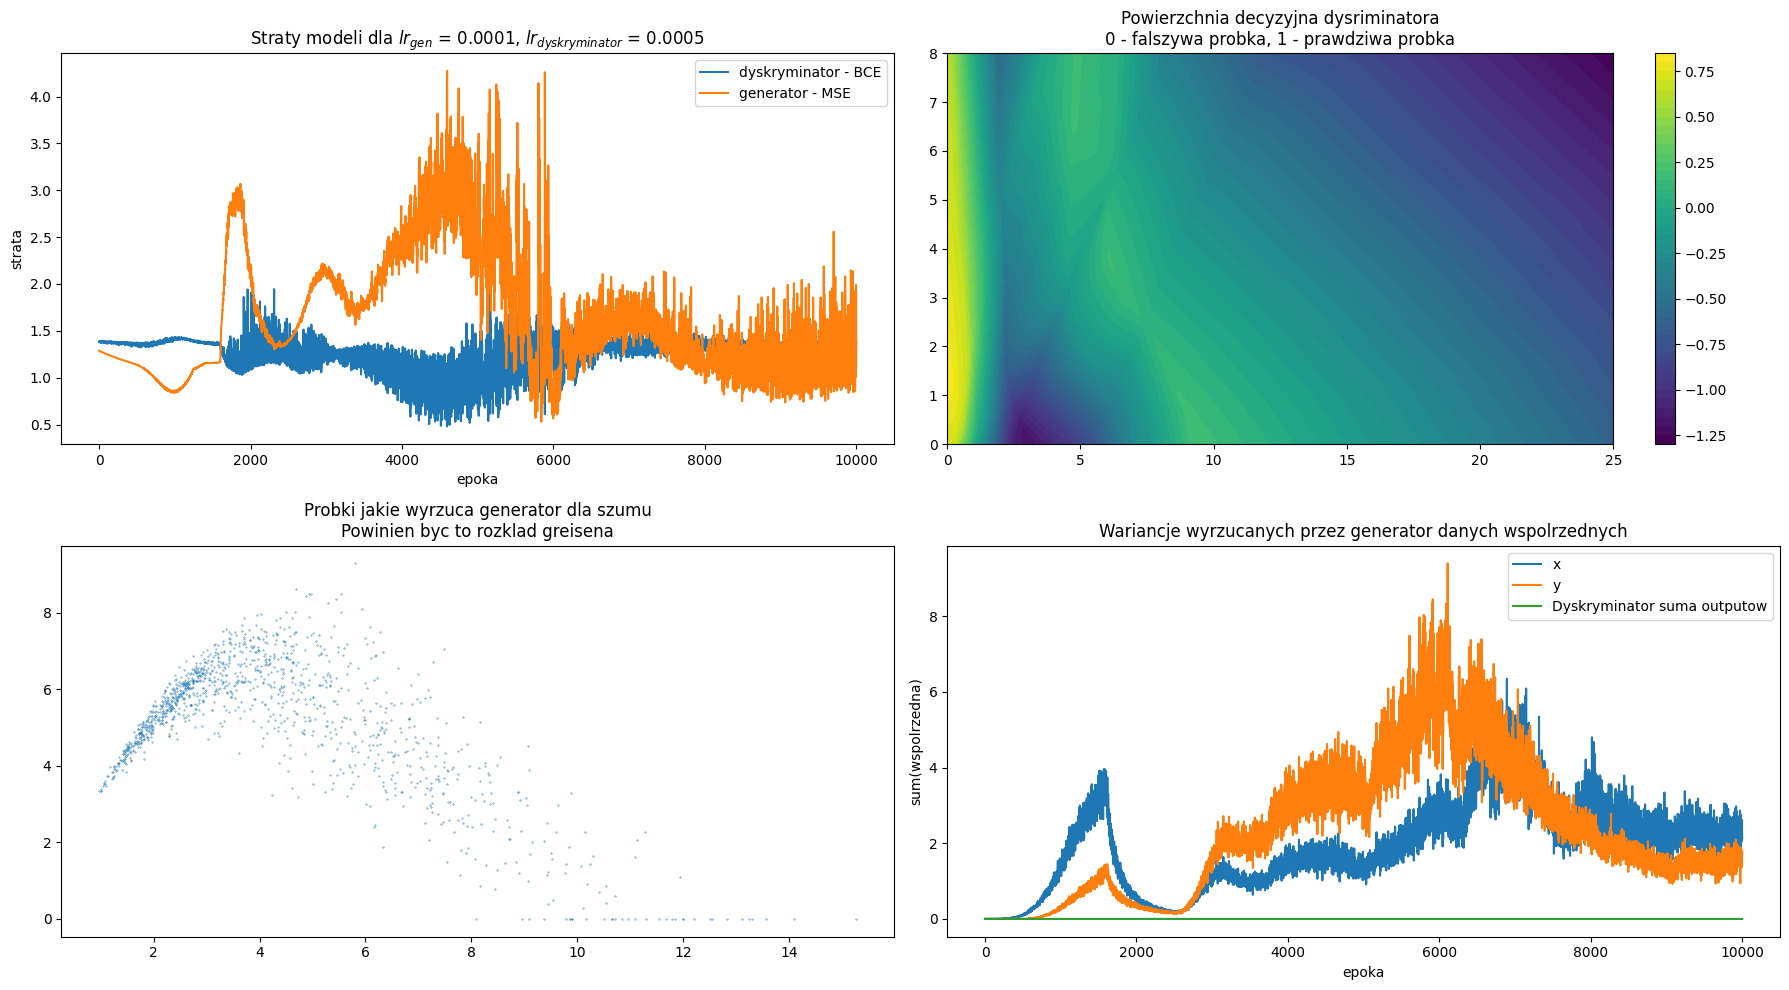

In [149]:
generator_layers = [ # bez konwolucji poki co, potem sie doda batchNorm i funkcje aktywacji
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.ReLU()
]
generator = Generator(generator_layers, 1e-4) #! Na e-4 juz sa za male lr-y nieco

discriminator_layers = [ #! Nie dodawaj sigmoida to sie nie sprawdza
    nn.Linear(2, 64),
    nn.LeakyReLU(0.2),
    nn.Linear(64, 32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 16),
    nn.LeakyReLU(0.2),
    nn.Linear(16, 8),
    nn.LeakyReLU(0.2),
    nn.Linear(8, 2),
    nn.LeakyReLU(0.2),
    nn.Linear(2, 1)
]
discriminator = Discriminator(discriminator_layers, 5e-4)

EPOCHS = 1_000
BATCH_SIZE = 64

var_x = np.zeros(EPOCHS)
var_y = np.zeros(EPOCHS)
var_discriminator= np.zeros((EPOCHS, 1))
steps_history = np.zeros(EPOCHS)
generator_losses = np.zeros(EPOCHS)
discriminator_losses = np.zeros(EPOCHS)

generator.train()
discriminator.train()

for epoch in range(EPOCHS):
    xs, ys = metropolis_hastings_probing(greisen, length=BATCH_SIZE)
    true_data = torch.FloatTensor(np.vstack([xs, ys]).T).cuda()
    
    noise = torch.randn(size=(BATCH_SIZE, 128)).cuda()
    fake_data = generator.layers(noise).detach()
    
    var_x[epoch] = np.std( fake_data.cpu().detach().numpy()[:, 0] )
    var_y[epoch] = np.std( fake_data.cpu().detach().numpy()[:, 1] )

    # steps = int(max(1, discriminator_losses[epoch-1] / generator_losses[epoch-1] if epoch > 0 else 0))
    discriminator_loss = discriminator.training_step(true_data, fake_data, 5, var_discriminator[epoch])

    # trenowanie generatora
    generator.zero_grad()
    fake_data = generator.layers(noise)
    fake_labels = discriminator.layers(fake_data)
    generator_loss = generator.loss(fake_labels, torch.ones_like(fake_labels).cuda())
    generator_loss.backward()
    generator.optim.step()

    # steps_history[epoch] = steps
    generator_losses[epoch] = generator_loss.item()
    discriminator_losses[epoch] = discriminator_loss.item()

    if np.isclose(var_x[epoch], 0.0) or np.isclose(var_y[epoch], 0.0):
        raise ValueError('Mode collapse')

var_discriminator = var_discriminator.reshape(-1,)

plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, steps_history)

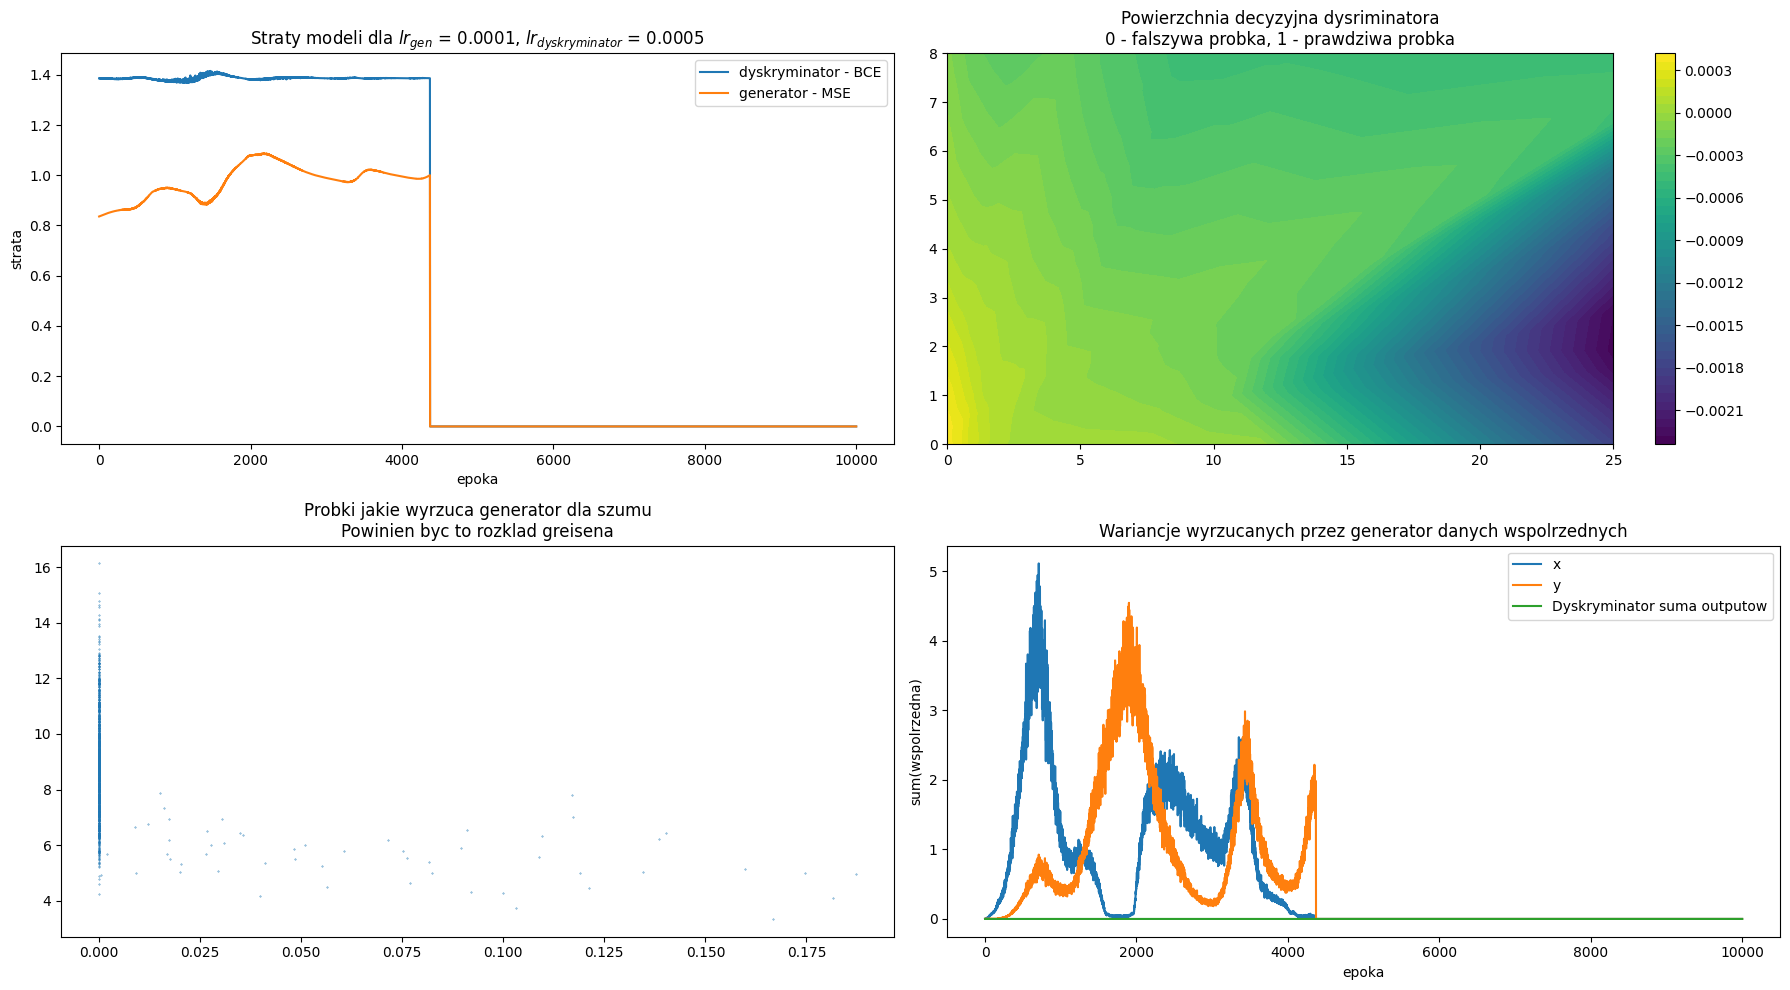

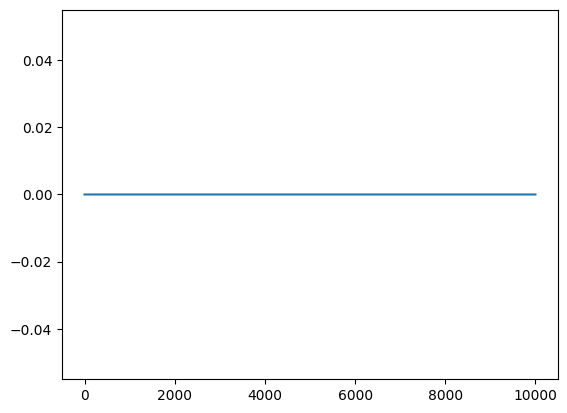

In [126]:
plot_basic_stats(var_x, var_y, generator_losses, discriminator_losses, steps_history)

plt.figure()
plt.plot(steps_history)
plt.show()